In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import sys
sys.path.append('/content/drive/MyDrive/Github/Time-series_price_analysis')

In [4]:
!ls /content/drive/MyDrive/Github/Time-series_price_analysis/*.py

/content/drive/MyDrive/Github/Time-series_price_analysis/make_dataset.py


## 0. Import Packages

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random as rn
import joblib
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from lightgbm import LGBMRegressor
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

import keras.layers
from keras import optimizers
from keras.layers import Activation, Lambda, Input
from keras.layers import Conv1D, SpatialDropout1D, Flatten
from keras.layers import Convolution1D, Dense, Reshape
from keras.models import Input, Model
from typing import List, Tuple

import tensorflow as tf
import os

from make_dataset import time_transform, make_input

In [6]:
# reproducibility
seed_num = 42
rn.seed(seed_num)
tf.random.set_seed(seed_num)
os.environ['PYTHONHASHSEED']=str(seed_num)

from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

## 1. Load and visualize dataset

In [7]:
df = pd.read_csv("/content/drive/MyDrive/Github/Time-series_price_analysis/dataset/AAPL.csv")
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,"Mar 25, 2022",174.73,173.90,175.27,172.77,73.63M,0.38%
1,"Mar 24, 2022",174.07,171.06,174.14,170.21,89.68M,2.27%
2,"Mar 23, 2022",170.21,167.99,172.64,167.65,97.30M,0.82%
3,"Mar 22, 2022",168.82,165.51,169.42,164.91,80.94M,2.08%
4,"Mar 21, 2022",165.38,163.51,166.35,163.01,95.81M,0.85%


In [8]:
df.tail()

,Date,Price,Open,High,Low,Vol.,Change %
2534,"Mar 02, 2012",19.47,19.44,19.53,19.38,431.71M,0.10%
2535,"Mar 01, 2012",19.45,19.58,19.58,19.24,683.25M,0.41%
2536,"Feb 29, 2012",19.37,19.34,19.56,19.13,952.00M,1.31%
2537,"Feb 28, 2012",19.12,18.86,19.12,18.78,600.39M,1.81%
2538,"Feb 27, 2012",18.78,18.62,18.87,18.44,547.58M,0.64%


In [9]:
df['Date'] = df['Date'].apply(lambda x: time_transform(x))
dataset = df.sort_values('Date').reset_index(drop=True)

In [10]:
print("Shape of dataset :", dataset.shape)
dataset.head()

Shape of dataset : (2539, 7)


,Date,Price,Open,High,Low,Vol.,Change %
0,2012-02-27,18.78,18.62,18.87,18.44,547.58M,0.64%
1,2012-02-28,19.12,18.86,19.12,18.78,600.39M,1.81%
2,2012-02-29,19.37,19.34,19.56,19.13,952.00M,1.31%
3,2012-03-01,19.45,19.58,19.58,19.24,683.25M,0.41%
4,2012-03-02,19.47,19.44,19.53,19.38,431.71M,0.10%


In [11]:
date = dataset['Date'].values
close = dataset['Price'].values

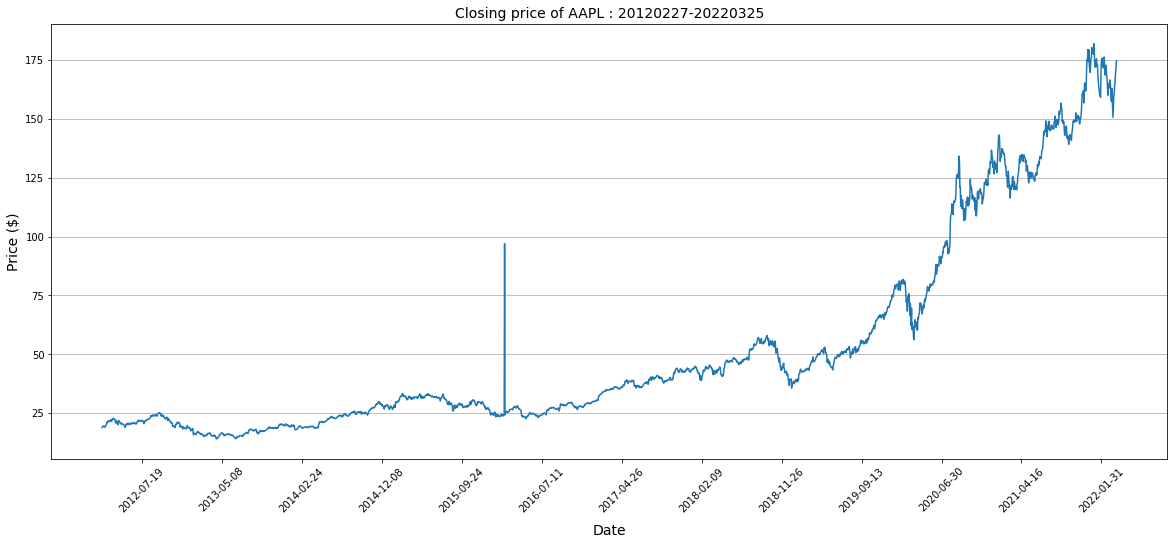

In [12]:
plt.figure(figsize=(20,8))
plt.plot(date, close)
plt.title("Closing price of AAPL : 20120227-20220325", fontsize = 14)
plt.xlabel('Date', fontsize = 14, labelpad=10)
plt.ylabel('Price ($)', fontsize = 14)
plt.xticks(np.arange(100,len(date),200), rotation=45)
plt.grid(True, axis='y')
plt.show()

## 2. Preprocessing

- Min-max scaling

In [57]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_close = scaler.fit_transform(np.array(close).reshape(-1,1))

In [58]:
print(scaled_close)

[[0.02873974]
 [0.03076282]
 [0.03225039]
 ...
 [0.92978698]
 [0.95275497]
 [0.95668214]]


- Split train and test dataset

In [59]:
train_size = int(len(close)*0.795)
val_size = len(close)-train_size
train_data, val_data = scaled_close[0:train_size,:], scaled_close[train_size:len(close),:1]

orig_train_data, orig_val_data = close[0:train_size], close[train_size:len(close)]
orig_train_data = np.reshape(orig_train_data, (orig_train_data.shape[0], 1))
orig_val_data = np.reshape(orig_val_data, (orig_val_data.shape[0], 1))

In [60]:
train_size,val_size

(2018, 521)

In [61]:
time_step = 1
X_train, y_train = make_input(train_data, time_step)
X_val, y_val = make_input(val_data, time_step)

orig_X_train, orig_y_train = make_input(orig_train_data, time_step)
orig_X_val, orig_y_val = make_input(orig_val_data, time_step)

In [62]:
print("X train shape :", X_train.shape)
print("y train shape :", y_train.shape)
print("X val shape :", X_val.shape)
print("y val shape :", y_val.shape)

X train shape : (2016, 1)
y train shape : (2016,)
X val shape : (519, 1)
y val shape : (519,)


In [63]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1] , 1)

print("X train shape :", X_train.shape)
print("X val shape :", X_val.shape)

X train shape : (2016, 1, 1)
X val shape : (519, 1, 1)


In [64]:
lstm_trainx, lstm_trainy = X_train, y_train
lstm_valx, lstm_valy = X_val, y_val

wave_trainx, wave_trainy = X_train, y_train
wave_valx, wave_valy = X_val, y_val

lgbm_trainx, lgbm_trainy = orig_X_train, orig_y_train
lgbm_valx, lgbm_valy = orig_X_val, orig_y_val

## 3. Load trained model

In [65]:
loaded_lstm = load_model("/content/drive/MyDrive/Github/Time-series_price_analysis/model_weights/aapl/lstm.pkl")
loaded_wavenet = load_model("/content/drive/MyDrive/Github/Time-series_price_analysis/model_weights/aapl/wavenet.pkl")
loaded_lgbm = joblib.load('/content/drive/MyDrive/Github/Time-series_price_analysis/model_weights/lgbm.pkl')

## 4. Evaluation

In [69]:
lstm_train_predicton = loaded_lstm.predict(lstm_trainx)
lstm_val_prediction = loaded_lstm.predict(lstm_valx)
lstm_train_pred = scaler.inverse_transform(lstm_train_predicton)
lstm_val_pred = scaler.inverse_transform(lstm_val_prediction)

wave_train_predicton = loaded_wavenet.predict(wave_trainx)
wave_val_prediction = loaded_wavenet.predict(wave_valx)
wave_train_predicton = np.reshape(wave_train_predicton, (wave_train_predicton.shape[0], 1))
wave_val_prediction = np.reshape(wave_val_prediction, (wave_val_prediction.shape[0], 1))
wave_train_pred = scaler.inverse_transform(wave_train_predicton)
wave_val_pred = scaler.inverse_transform(wave_val_prediction)

lgbm_train_pred = loaded_lgbm.predict(lgbm_trainx)
lgbm_val_pred = loaded_lgbm.predict(lgbm_valx)

print(lstm_val_pred[:5], '\n\n', wave_val_pred[:5], '\n\n', lgbm_val_pred[:5] )

[[76.45923 ]
 [73.999954]
 [73.02791 ]
 [67.31676 ]
 [72.096855]] 

 [[76.32148 ]
 [73.79951 ]
 [72.798355]
 [66.99681 ]
 [71.83712 ]] 

 [75.36302961 73.0791612  73.0791612  66.53690579 71.02891821]


In [78]:
lstm_val_rmse = math.sqrt(mean_squared_error(orig_y_val, lstm_val_pred))
wave_val_rmse = math.sqrt(mean_squared_error(orig_y_val, wave_val_pred))
lgbm_val_rmse = math.sqrt(mean_squared_error(orig_y_val, lgbm_val_pred))

print('Val RMSE of LSTM: %.3f' % lstm_val_rmse)
print('Val RMSE of Wavenet: %.3f' % wave_val_rmse)
print('Val RMSE of LightGBM: %.3f' % lgbm_val_rmse)

Val RMSE of LSTM: 2.688
Val RMSE of Wavenet: 2.779
Val RMSE of LightGBM: 57.708


## 5. Visualization

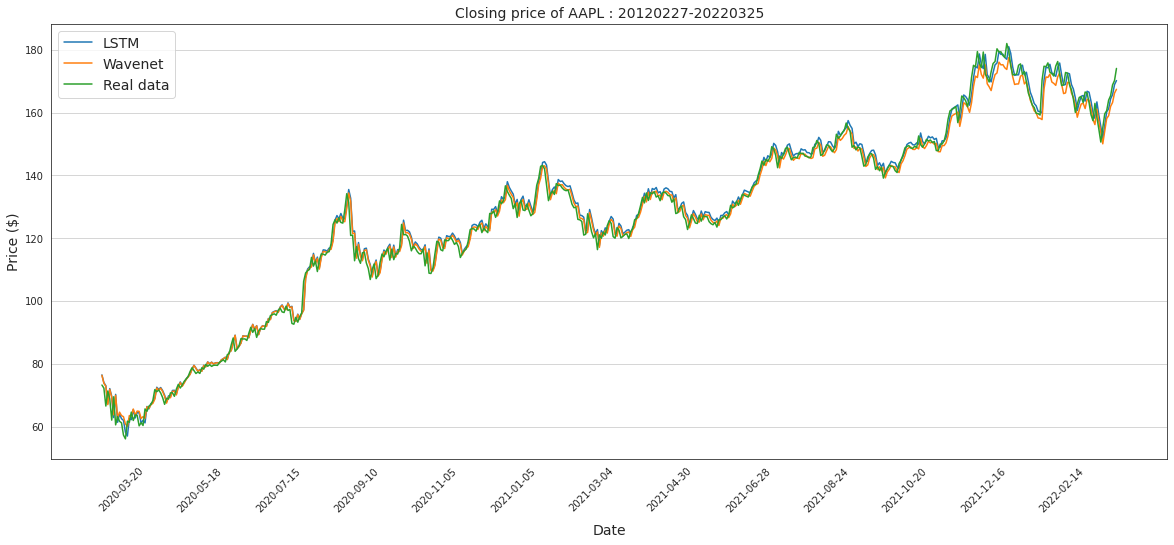

In [80]:
plt.figure(figsize=(20,8))
plt.plot(date[-len(orig_y_val):], lstm_val_pred, label='LSTM')
plt.plot(date[-len(orig_y_val):], wave_val_pred, label='Wavenet')
# plt.plot(date[-len(orig_y_val):], lgbm_val_pred, label='LightGBM')
plt.plot(date[-len(orig_y_val):], orig_y_val, label='Real data')
plt.legend(fontsize = 14)
plt.title("Closing price of AAPL : 20120227-20220325", fontsize = 14)
plt.xlabel('Date', fontsize = 14, labelpad=10)
plt.ylabel('Price ($)', fontsize = 14)
plt.xticks(np.arange(10, len(orig_y_val), 40), rotation=45)
plt.grid(True, axis='y')
plt.show()

- zoom in

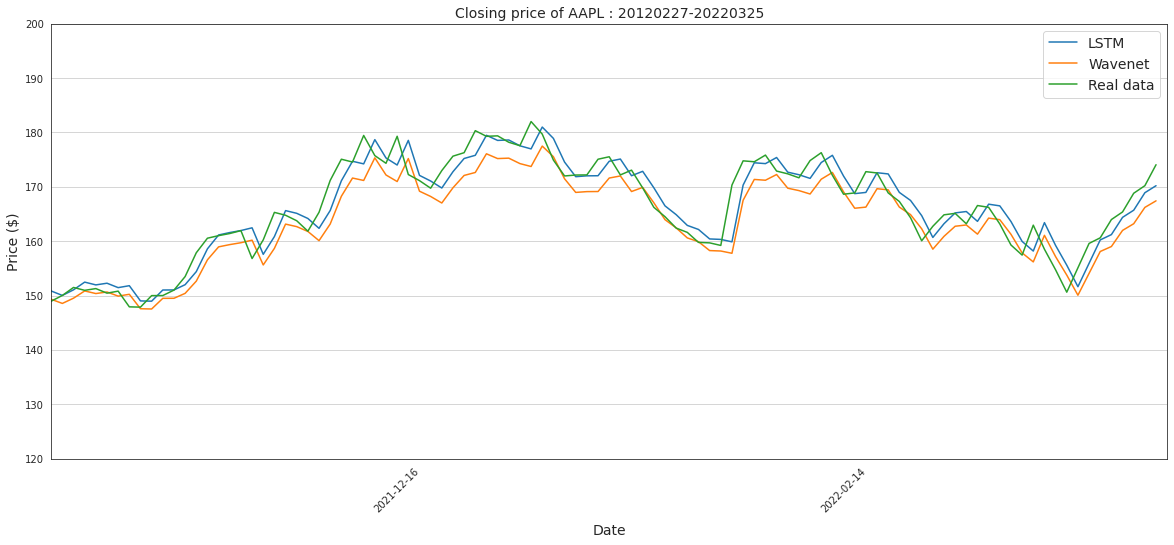

In [72]:
plt.figure(figsize=(20,8))
plt.plot(date[-len(orig_y_val):], lstm_val_pred, label='LSTM')
plt.plot(date[-len(orig_y_val):], wave_val_pred, label='Wavenet')
# plt.plot(date[-len(orig_y_val):], lgbm_val_pred, label='LightGBM')
plt.plot(date[-len(orig_y_val):], orig_y_val, label='Real data')
plt.legend(fontsize = 14)
plt.title("Closing price of AAPL : 20120227-20220325", fontsize = 14)
plt.xlabel('Date', fontsize = 14, labelpad=10)
plt.ylabel('Price ($)', fontsize = 14)
plt.xticks(np.arange(10, len(orig_y_val), 40), rotation=45)
plt.grid(True, axis='y')
plt.axis([419, 519, 120, 200])
plt.show()

In [38]:
cycle = np.arange(len(close))
cycle1 = cycle[0:train_size-2]
cycle2 = cycle[train_size+2:len(close)]

print(np.shape(cycle1), np.shape(cycle2))

(2016,) (519,)


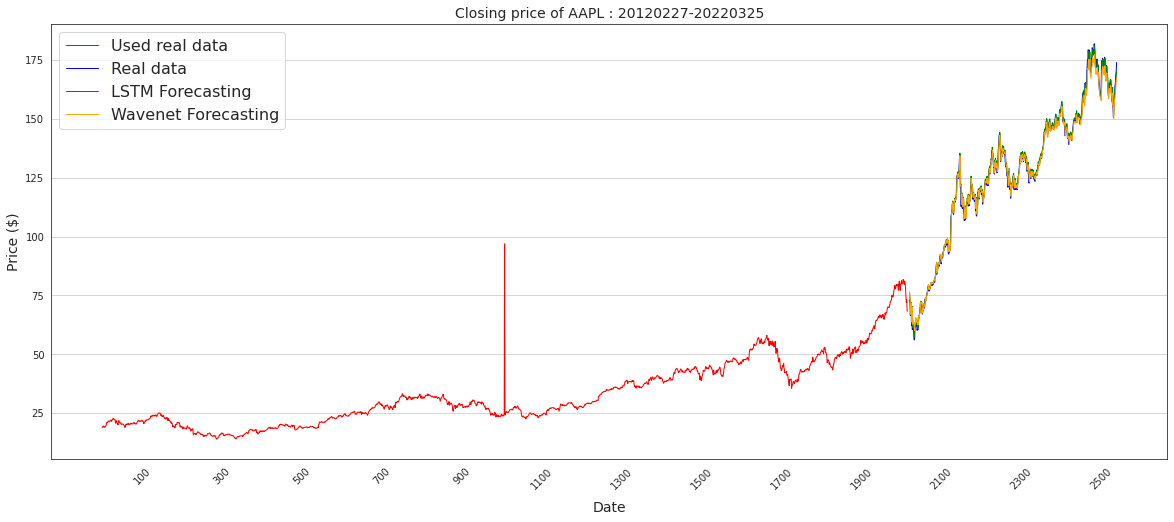

In [83]:
sns.set_style("white")
plt.figure(figsize=(20,8))

plt.plot(cycle1, orig_X_train[:,0],label='Used real data', linewidth = 1, color='r')
plt.plot(cycle2, orig_y_val,label='Real data', linewidth = 1, color='b')
plt.plot(cycle2, lstm_val_pred[:,0],label='LSTM Forecasting', linewidth = 1, color='g')
plt.plot(cycle2, wave_val_pred[:,0],label='Wavenet Forecasting', linewidth = 1, color='orange')
# plt.plot(cycle2, lgbm_val_pred[:],label='LightGBM Forecasting', linewidth = 1, color='brown')
plt.legend(prop={'size': 16})

plt.title("Closing price of AAPL : 20120227-20220325", fontsize = 14)
plt.xlabel('Date', fontsize = 14, labelpad=10)
plt.ylabel('Price ($)', fontsize = 14)
plt.xticks(np.arange(100,len(date),200), rotation=45)
plt.grid(True, axis='y')
plt.show()

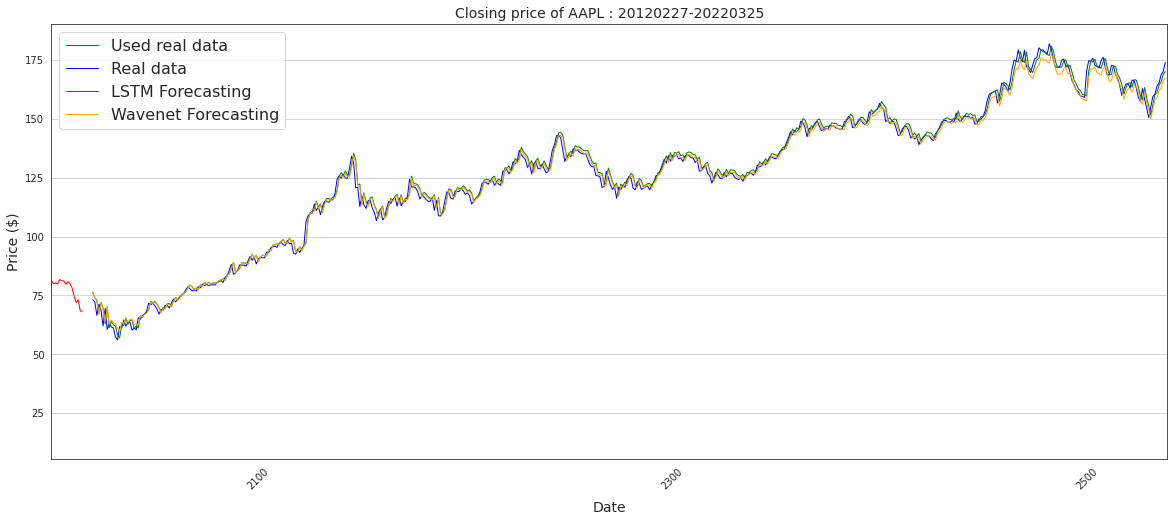

In [84]:
sns.set_style("white")
plt.figure(figsize=(20,8))

plt.plot(cycle1, orig_X_train[:,0],label='Used real data', linewidth = 1, color='r')
plt.plot(cycle2, orig_y_val,label='Real data', linewidth = 1, color='b')
plt.plot(cycle2, lstm_val_pred[:,0],label='LSTM Forecasting', linewidth = 1, color='g')
plt.plot(cycle2, wave_val_pred[:,0],label='Wavenet Forecasting', linewidth = 1, color='orange')
# plt.plot(cycle2, lgbm_val_pred[:],label='LightGBM Forecasting', linewidth = 1, color='brown')
plt.legend(prop={'size': 16})

plt.title("Closing price of AAPL : 20120227-20220325", fontsize = 14)
plt.xlabel('Date', fontsize = 14, labelpad=10)
plt.ylabel('Price ($)', fontsize = 14)
plt.xticks(np.arange(100,len(date),200), rotation=45)
plt.xlim(2000, 2539)
plt.grid(True, axis='y')
plt.show()